In [16]:
import pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns

##Loading Time Series Data

In [36]:
data=pd.read_csv('AirPassengers.csv')
#Convert object column to datetime as time series cannot handle object datatype
data['Month']=pd.to_datetime(data['Month'])
#Changing column to index
data.index=data['Month']
del data['Month']
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


##Time Series Visualization
Plotting the Time series can help in analyzing the visible trends, seasonality in the data. Use visualization library to create simple line plots to study the data.

<Axes: xlabel='Month'>

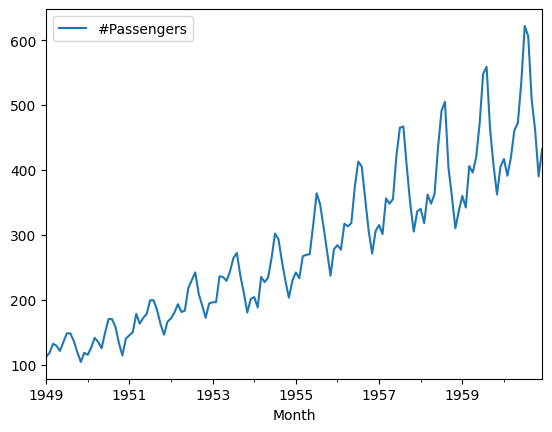

In [18]:
data.plot()

##Time Series Analysis
From the plot drawn in the previous section, clearly there are a few patterns. There is a upward trend in the data with seasonality. To understand this, take a look at various patterns to identify from time series plots.

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

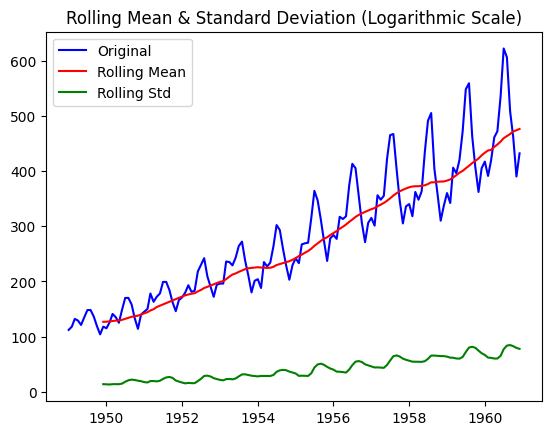

In [19]:
mean_log=data.rolling(window=12).mean()
std_log=data.rolling(window=12).std()

plt.plot(data,color='blue',label='Original')
plt.plot(mean_log,color='red',label='Rolling Mean')
plt.plot(std_log,color='green',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

The rolling mean and standard deviation on the original time series data shows a constant increase in the mean.

##Stationarity in a Time Series
Before beginning modeling with the ARIMA model for forecasting, make sure the time series data is stationary. In simple terms, if a data consists of trends
and seasonality, the data is not going to be a stationary data. In this case, there is both, so take a look at how this can be fix this

To find the stationarity in a data, we can use the statistical test such as Augmented Dickey Fuller(adfuller) test.


Consider two hypotheses, a null hypotheses and an alternate hypotheses. If the null hypotheses is rejected after the computation, the time series is stationary series.


To reject the null hypotheses, the following must be true:
1. If the p-value after the adfuller test is greater than 0.05, the hypotheses cannot be rejected.
2. If the p-value is less than 0.05, the null hypotheses can be rejected and it can be assumed that the time series is stationary.

In [20]:
#Checking stationarity of the series
from statsmodels.tsa.stattools import adfuller
result=adfuller(data['#Passengers'])
result

(0.8153688792060498,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

The p-value from the result is on the index 1, and it can be checked if the data is stationary or not. In this case, the p-value = 0.9918 which is more
than 0.05 and thus, the null hypotheses cannot be rejected and it can be assumed that the data is non-stationary.

##Time Series Differencing
Differencing in time series is the process of reducing the non-stationary time series to a stationary time series with a series of subtraction operations i.e. subtracting the observations from one another.


There are several ways to make the time series stationary

1. Differencing is the most common technique to make time series stationary.
2. Log transformations of the time series is another technique to make the time series stationary.
3. Power transformation can also be used

Using the log transformation here to make the time series stationary

<Axes: xlabel='Month'>

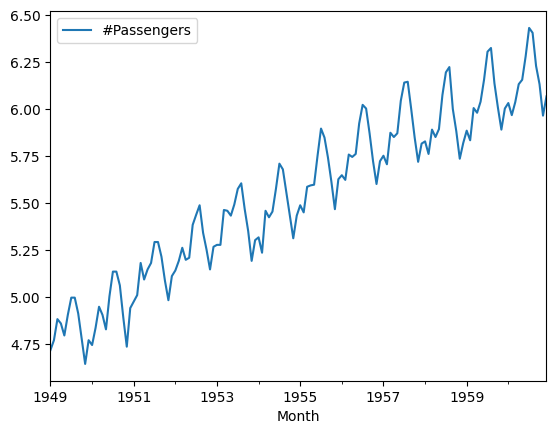

In [21]:
#Logarithmic computation to make time series stationary
first_log=np.log(data)
first_log=first_log.dropna()
first_log.plot()

Plotting the rolling standard deviation, and rolling mean on the log transformed data

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

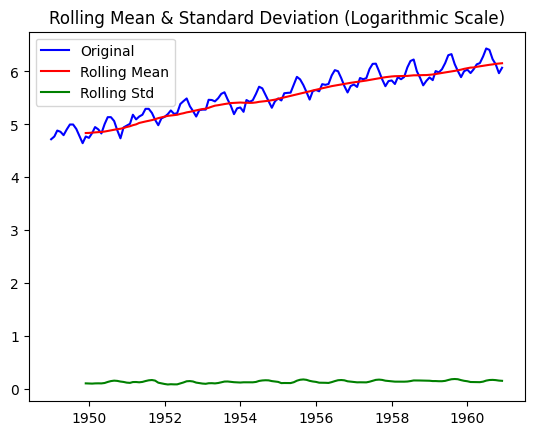

In [22]:
mean_log=first_log.rolling(window=12).mean()
std_log=first_log.rolling(window=12).std()

plt.plot(first_log,color='blue',label='Original')
plt.plot(mean_log,color='red',label='Rolling Mean')
plt.plot(std_log,color='green',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

From the plot, it is evident that the time series is improved a little in terms of mean and standard deviation

##Removing Trends and Seasonality
Creating a new time series by subtracting the rolling mean with the log transformed time series.

In [23]:
new_data=first_log-mean_log
new_data=new_data.dropna()
new_data.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithm Scale)')

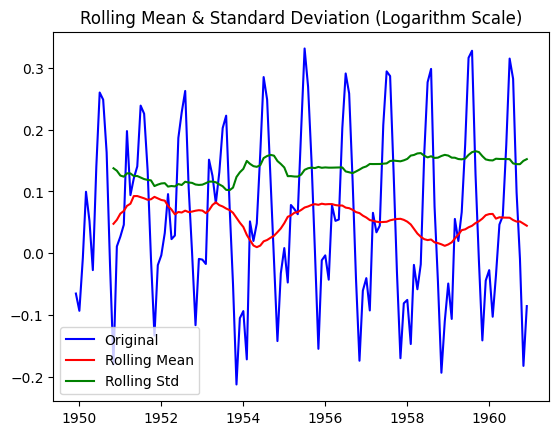

In [24]:
mean_log=new_data.rolling(window=12).mean()
std_log=new_data.rolling(window=12).std()

plt.plot(new_data,color='blue',label='Original')
plt.plot(mean_log,color='red',label='Rolling Mean')
plt.plot(std_log,color='green',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithm Scale)')

After plotting the rolling mean and standard deviation, it is observed that the mean and standard deviation is slightly improved

Perform Adfuller test on the new detrended time series to check the stationarity of the time
series.

In [25]:
result=adfuller(new_data['#Passengers'])
result

(-3.1629079913008833,
 0.022234630001242206,
 13,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 -436.63269481747034)

The p-value from the result is less than 0.05, therefore now the null hypotheses can be rejected and the time series can be considered to be stationary

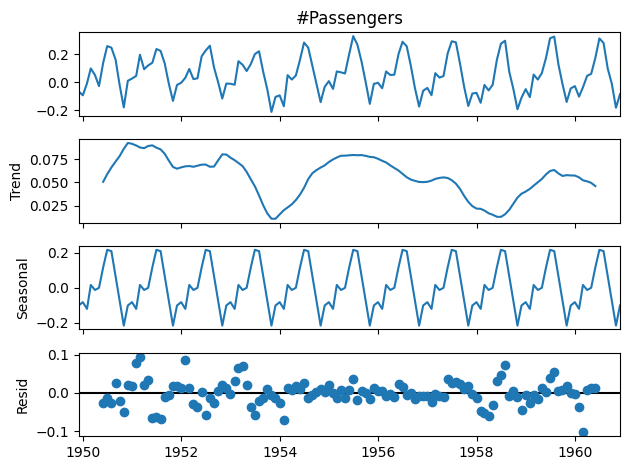

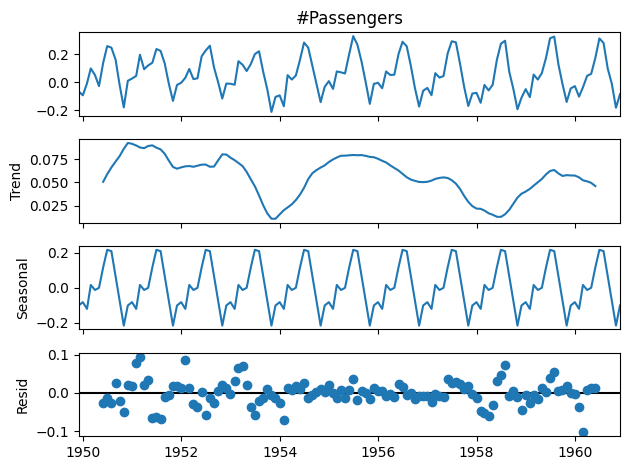

In [26]:
#Seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result=seasonal_decompose(new_data['#Passengers'].dropna())
decompose_result.plot()

The seasonal decomposition shows the
trend to be removed, but the seasonality
might still be present in the time series.

##Autocorrelation and Partial Autocorrelation
Use the autocorrelation plot to
determine the q value for the ARIMA
order.

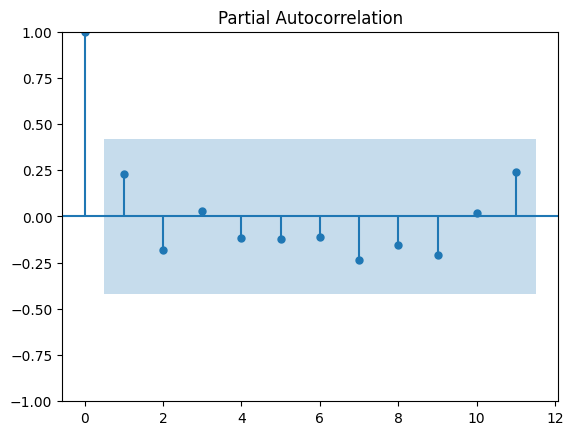

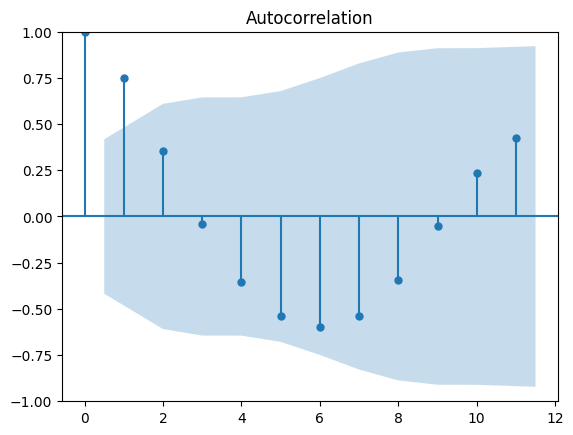

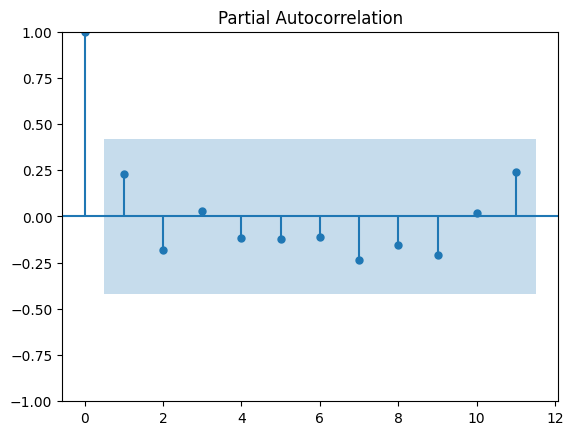

In [28]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf_plot=acf(new_data)
pacf_plot=pacf(new_data)
plot_acf(acf_plot)
plot_pacf(pacf_plot)

Use the Partial autocorrelation plot to
determine the p value for the ARIMA
order.

##ARIMA Model For Time Series Forecasting
ARIMA model is the combination of Autoregressive(AR), Integrated (I), and Moving Average(MA) models.

Here, p, d and q are the order of AR, order of differencing and order of MA respectively. These values are
already calculated using the autocorrelation and partial autocorrelation plots, or these values can also be deduced using the ACF and PCF

In [30]:
from statsmodels.tsa.arima.model import ARIMA

train=new_data.iloc[:120]['#Passengers']
test=new_data[121:]['#Passengers']

model=ARIMA(train,order=(1,0,2))
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  120
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 117.901
Date:                Tue, 02 Jan 2024   AIC                           -225.803
Time:                        06:33:29   BIC                           -211.865
Sample:                    12-01-1949   HQIC                          -220.143
                         - 11-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0538      0.022      2.446      0.014       0.011       0.097
ar.L1          0.4323      0.318      1.361      0.173      -0.190       1.055
ma.L1          0.5917      0.323      1.829      0.067      -0.042       1.226
ma.L2         -0.0778      0.279     -0.279      0.780      -0.625       0.469
sigma2         0.0081      0.002      4.769      0.000       0.005       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.02
Prob(Q):                              0.92   Prob(JB):                         0.05
Heteroskedasticity (H):               1.21   Skew:                            -0.08
Prob(H) (two-sided):                  0.55   Kurtosis:                         1.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ARIMA model is fit on the training data using the order - (1,0,2). The
order of differencing is taken as 0 since the new transformed time series is used for the model.

<Axes: xlabel='Month'>

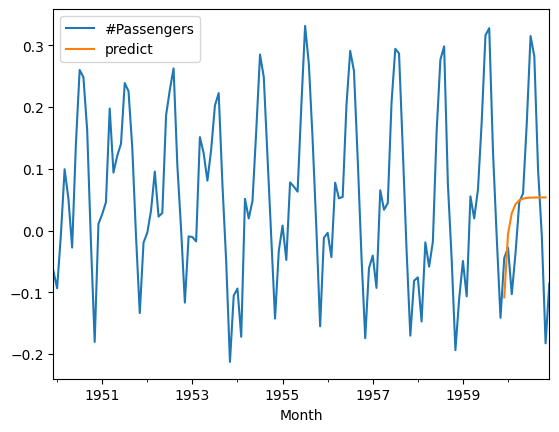

In [32]:
new_data['predict']=model_fit.predict(start=len(train),
                    end=len(train)+len(test)-1,
                    dynamic=True)
new_data[['#Passengers','predict']].plot()

As shown in above graph,  the
predictions are way off the
actual values from the test
set. Therefore, seasonal ARIMA model can be tried for forecasting

##SARIMA Model For Time Series Forecasting
In the seasonal ARIMA model, it is expected to specify the seasonal order as well. The seasonal order remains the same as the ARIMA order, and the periodic order can be added in the seasonal order according to the periodicity.

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX,SARIMAXResults
model=SARIMAX(train,order=(1,0,2),seasonal_order=(1,0,2,12))
model=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Month'>

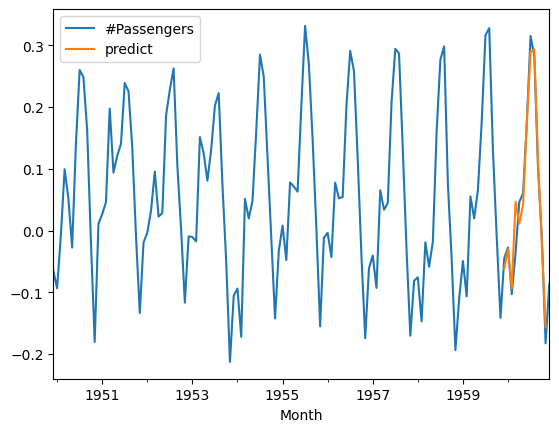

In [34]:
new_data['predict']=model.predict(start=len(train),
                    end=len(train)+len(test)-1,
                    dynamic=True)
new_data[['#Passengers','predict']].plot()

Here, the predicted values
on the test set are more accurate than
the ARIMA model. Therefore a Time series
forecast model is successfully created. Now use this model to forecast the time series.

##Inferences

<Axes: xlabel='Month'>

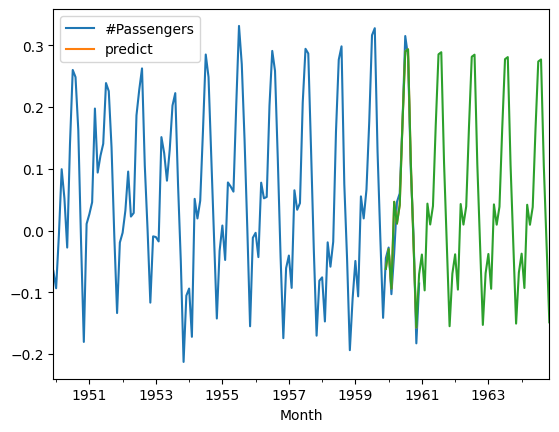

In [35]:
forecast=model.forecast(steps=60)
new_data.plot()
forecast.plot()

The model was trained the model on the
transformed time series, therefore the
predictions are aligned to the same.
The model can be trained with the
original dataset, and add the order of
differencing manually and get the
predictions on the actual values. Or
reverse transform the predictions and
plot with the original series.

Here forecasting for upcoming 5 years is sucessfully predicted as well as visualized